In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import torch
import torchvision

import pandas as pd
import numpy as np
import seaborn as sns 
import albumentations as A
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.cli import tqdm
from pytorch_toolbelt.inference import tta

from src.data import EyeDataset
from src.utils import load_splits
from src.utils import custom_to_std_tensor
from src.utils import denormalize
from src.utils import eye_blend
from src.config import ConfigParser
from src.config import load_config_from_ckpt
from src.models import ModelEnsemble

In [3]:
data_folder = Path("data")
folds_folder = Path("folds")
models_folder = Path("models")
configs_folder = Path("configs")
figs_folder = Path("figs")
output_folder = Path("output")
submissions_folder = Path("submissions")

test_df = pd.read_csv(data_folder / "test.csv")

In [9]:
config_filename = configs_folder / "baseline.yml"
checkpoint_filename = models_folder / "baseline-epoch-38-ckpt.pt"
config = load_config_from_ckpt(config_filename, checkpoint_filename)

model = config.model
model.eval();
model = tta.TTAWrapper(model, tta.fliplr_image2mask)

Overwriting device = gpu (was gpu)
Overwriting non-existing attribute checkpoint.filename = models/baseline-epoch-38-ckpt.pt
Overwriting non-existing attribute checkpoint.filename = models/baseline-epoch-38-ckpt.pt
Overwriting non-existing attribute checkpoint.model = True
{'model': {'name': 'models.smp.Unet', 'params': {'encoder_name': 'efficientnet-b2', 'encoder_weights': 'imagenet', 'in_channels': 1, 'classes': 4, 'activation': None}}, 'device': 'gpu', 'criterion': {'name': 'L.JaccardLoss', 'params': {'mode': 'multiclass'}}, 'optimizer': {'name': 'torch.optim.Adam', 'params': {'lr': 0.001}}, 'scheduler': {'name': 'torch.optim.lr_scheduler.ReduceLROnPlateau', 'params': {'patience': 10, 'factor': 0.5, 'mode': 'max'}}, 'dataloaders': {'train': {'name': 'torch.utils.data.DataLoader', 'params': {'dataset': {'name': 'data.EyeDataset', 'params': {'df': {'name': 'utils.load_splits', 'params': {'folds_folder': {'path': 'folds'}, 'val_folds': [0], 'only_train': True}}, 'mode': 'train', 'trans

In [ ]:
# transform = A.Compose([
#     A.Resize(384,  640),
#     custom_to_std_tensor,
# ])
# dataset = EyeDataset(test_df, "test", transform, return_pos=True)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, num_workers=10)

dataset = config.dataloaders.test.dataset
dataloader = config.dataloaders.test

## Inference single image

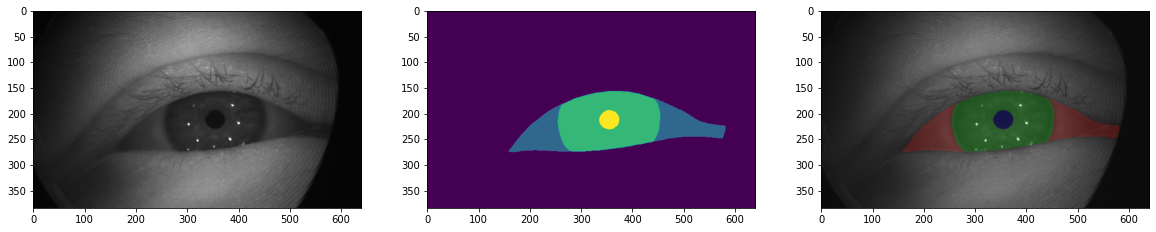

In [42]:
img, pos = dataset[23425]

with torch.no_grad():
    imgs = img.to(config.device).unsqueeze(0)
    outs = model(imgs.to(device))
    outs = outs.argmax(1)
    mask = outs.detach().cpu()[0]

    
img_arr = np.array(torchvision.transforms.functional.to_pil_image(denormalize(img)))
mask_arr = mask.numpy()

blend = eye_blend(img, mask)


plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_arr, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(mask_arr)
plt.subplot(1, 3, 3)
plt.imshow(blend)
plt.savefig(figs_folder / "baseline-out", bbox_inches="tight")

## Inference all

In [8]:
model.eval()
shape = (640, 400)
filenames = []
with torch.no_grad():
    for imgs, pos in tqdm(dataloader):
        imgs = imgs.to(config.device)
        outs = model(imgs)
        outs = outs.argmax(1).cpu()
        
        seqs = pos[0].long().tolist()
        orders = pos[1].long().tolist()
        
        for out, seq, order in zip(outs, seqs, orders):
            out = out.numpy().astype(np.uint8)
            out = cv2.resize(out, shape)
            filename = f"S_{seq}/{order}.npy"
            path = output_folder / filename
            path.parent.mkdir(parents=True, exist_ok=True)
            np.save(path, out)
            filenames.append(filename)
with open(output_folder / "output.txt", "w") as output_file:
    output_file.writelines("\n".join(filenames))

## Ensemble inference

In [4]:
configs = [
    load_config_from_ckpt(
        configs_folder / "baseline.yml",
        models_folder / "baseline-epoch-38-ckpt.pt",
        verbose=False,
    ),
    load_config_from_ckpt(
        configs_folder / "baseline-fold-1.yml",
        models_folder / "baseline-fold-1-epoch-43-ckpt.pt",
        verbose=False,
    ),  
    load_config_from_ckpt(
        configs_folder / "baseline-fold-2.yml",
        models_folder / "baseline-fold-2-epoch-43-ckpt.pt",
        verbose=False,
    ),   
    load_config_from_ckpt(
        configs_folder / "baseline-fold-3.yml",
        models_folder / "baseline-fold-3-epoch-40-ckpt.pt",
        verbose=False,
    ),   
]

model = ModelEnsemble([cnfg.model for cnfg in configs])
model.eval()
model = tta.TTAWrapper(model, tta.fliplr_image2mask)

transform = A.Compose([
    A.Resize(384,  640),
    custom_to_std_tensor,
])
dataset = EyeDataset(test_df, "test", transform, return_pos=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Overwriting device = gpu (was gpu)
Overwriting non-existing attribute checkpoint.filename = models/baseline-epoch-38-ckpt.pt
Overwriting non-existing attribute checkpoint.filename = models/baseline-epoch-38-ckpt.pt
Overwriting non-existing attribute checkpoint.model = True
Load model from state dict
Overwriting device = gpu (was gpu)
Overwriting non-existing attribute checkpoint.filename = models/baseline-fold-1-epoch-43-ckpt.pt
Overwriting non-existing attribute checkpoint.filename = models/baseline-fold-1-epoch-43-ckpt.pt
Overwriting non-existing attribute checkpoint.model = True
Load model from state dict
Overwriting device = gpu (was gpu)
Overwriting non-existing attribute checkpoint.filename = models/baseline-fold-2-epoch-43-ckpt.pt
Overwriting non-existing attribute checkpoint.filename = models/baseline-fold-2-epoch-43-ckpt.pt
Overwriting non-existing attribute checkpoint.model = True
Load model from state dict
Overwriting device = gpu (was gpu)
Overwriting non-existing attribute

In [5]:
model.eval()
shape = (640, 400)
filenames = []
with torch.no_grad():
    for imgs, pos in tqdm(dataloader):
        imgs = imgs.to(device)
        outs = model(imgs)
        outs = outs.argmax(1).cpu()
        
        seqs = pos[0].long().tolist()
        orders = pos[1].long().tolist()
        
        for out, seq, order in zip(outs, seqs, orders):
            out = out.numpy().astype(np.uint8)
            out = cv2.resize(out, shape)
            filename = f"S_{seq}/{order}.npy"
            path = output_folder / filename
            path.parent.mkdir(parents=True, exist_ok=True)
            np.save(path, out)
            filenames.append(filename)
with open(output_folder / "output.txt", "w") as output_file:
    output_file.writelines("\n".join(filenames))

100%|██████████| 1742/1742 [43:38<00:00,  1.50s/it]
